# Quick Draw Dataset

In this notebook, a model trained on subset of Quick Draw dataset is ananlysed. I use only 340,000 images in total, i.e., 1000 images per category. Also, I convert samples from strokes into images on the fly during training process. Probably it makes more sense to save everything onto disk at first. However, for a basic analysis and overview it should be fine to go with this approach.

## Imports

In [1]:
import sys
from pathlib import Path
from itertools import chain, cycle

In [2]:
parent_dir = Path.cwd().parent.as_posix()
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from PIL import ImageDraw as PILDraw

import torch
from torchvision import models
from fastai import defaults
from fastai.vision import create_cnn, ImageDataBunch, imagenet_stats, get_transforms, ClassificationInterpretation

In [4]:
from doodles_dataset import QuickDraw, TRAIN_DATA, PREPARED

In [5]:
defaults.device = torch.device('cuda:1')

## Dataset Review

In [6]:
!ls $TRAIN_DATA

 airplane.csv		 firetruck.csv	        postcard.csv
'alarm clock.csv'	 fish.csv	        potato.csv
 ambulance.csv		 flamingo.csv	       'power outlet.csv'
 angel.csv		 flashlight.csv         purse.csv
'animal migration.csv'	'flip flops.csv'        rabbit.csv
 ant.csv		'floor lamp.csv'        raccoon.csv
 anvil.csv		 flower.csv	        radio.csv
 apple.csv		'flying saucer.csv'     rainbow.csv
 arm.csv		 foot.csv	        rain.csv
 asparagus.csv		 fork.csv	        rake.csv
 axe.csv		 frog.csv	       'remote control.csv'
 backpack.csv		'frying pan.csv'        rhinoceros.csv
 banana.csv		 garden.csv	        river.csv
 bandage.csv		'garden hose.csv'      'roller coaster.csv'
 barn.csv		 giraffe.csv	        rollerskates.csv
'baseball bat.csv'	 goatee.csv	        sailboat.csv
 baseball.csv		'golf club.csv'         sandwich.csv
 basketball.csv		 grapes.csv	        saw.csv
 basket.csv		 grass.csv	        saxophone.csv
 bat.csv		 guitar.csv	       'school bus.csv'
 bathtub.csv		 hamburger.csv	    

In [10]:
dogs = pd.read_csv(TRAIN_DATA/'dog.csv')
dogs = dogs[dogs.recognized]

In [11]:
dogs.sample(5)

,countrycode,drawing,key_id,recognized,timestamp,word
98397,US,"[[[53, 20, 4, 0, 4, 20, 44, 63, 80, 87, 87, 83...",5271819160387584,True,2017-03-01 18:43:06.755780,dog
37714,SE,"[[[182, 173, 170, 170, 175, 189, 192, 197], [0...",5228120133074944,True,2017-03-23 08:07:58.081500,dog
128211,RU,"[[[54, 30, 6, 0, 0, 4, 18, 43, 62, 63, 60], [9...",5506734913224704,True,2017-03-06 05:12:50.940610,dog
50678,US,"[[[65, 39, 14, 4, 0, 2, 10, 43, 79, 120, 142, ...",4534722514386944,True,2017-01-23 18:16:36.111920,dog
19969,RS,"[[[77, 75, 68, 59, 42, 26, 7, 0, 0, 7, 31, 51,...",4797992735342592,True,2017-01-23 19:37:16.843030,dog


In [12]:
def to_flat_list(segments):
    return list(chain(*chain(*[zip(*segment) for segment in eval(segments)])))

In [13]:
flat_coords = dogs.drawing.sample(1000).map(to_flat_list)
min_val = flat_coords.map(min).min()
max_val = flat_coords.map(max).max()
print(f'Doodle coordinates are in range from {min_val} to {max_val}')

Doodle coordinates are in range from 0 to 255


In [14]:
COLORS = cycle(['#0095EF', '#3C50B1', '#6A38B3', '#A224AD', '#F31D64', '#FE433C'])

In [15]:
def to_pil_image(strokes, size=max_val+1, color='white', lw=3, colors=COLORS):
    canvas = PILImage.new('RGB', (size, size), color='white')
    draw = PILDraw.Draw(canvas)
    for segment, color in zip(strokes, colors):
        xs, ys = segment
        prev_pts = zip(xs[:-1], ys[:-1])
        next_pts = zip(xs[1:], ys[1:])
        for (x1, y1), (x2, y2) in zip(prev_pts, next_pts):
            draw.line((x1, y1, x2, y2), fill=color, width=lw)
    return canvas

In [16]:
def draw_sample(df, title=None, n=16, n_cols=4, figsize=(10, 10), dpi=70):
    n_rows = n//n_cols
    f, axes = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=dpi)
    examples = df.sample(n).drawing.map(eval)
    for strokes, ax in zip(examples, axes.flat):
        img = to_pil_image(strokes)
        ax.imshow(img)
        ax.set_axis_off()
    if title is not None:
        f.suptitle(title, fontsize=20)
    f.tight_layout(rect=[0, 0.03, 1, 0.95])

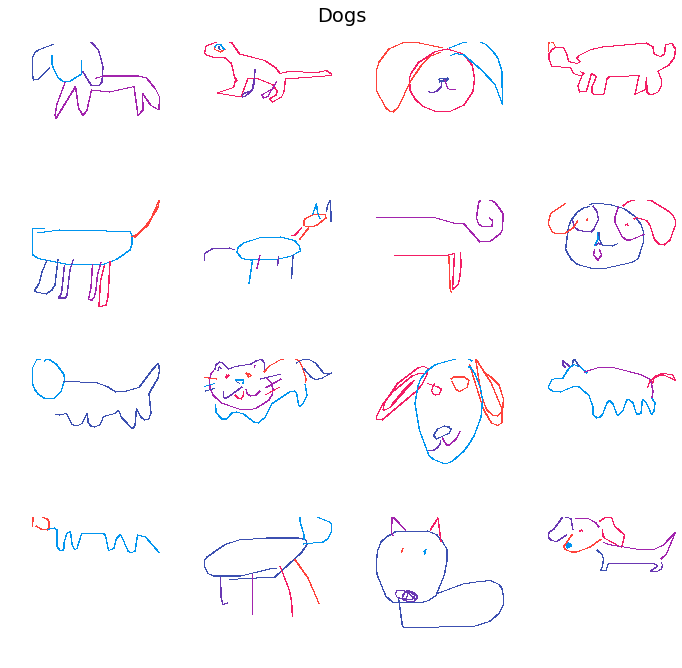

In [17]:
draw_sample(dogs, 'Dogs')

## Custom Dataset

The custom dataset definition is provided in [doodles_dataset.py](./doodles_dataset.py) file. The main idea here is to load CSV file only, and then generate strokes into PIL images on demand. The logic here is that reading small b/w image from I/O device probably comparable with generating it from scratch. 

Here is a part of PyTorch Dataset API which takes sequence of (x, y) coordinates concatenated into single comma-separated string and converts it into image:

```python
def __getitem__(self, item):
    points, target = self.data[item], self.labels[item]
    image = self.to_pil_image(points)
    return image, target

def to_pil_image(self, points):
    canvas = PILImage.new('RGB', self.img_size, color=self.bg_color)
    draw = PILDraw.Draw(canvas)
    chunks = [int(x) for x in points.split(',')]
    while len(chunks) >= 4:
        line, chunks = chunks[:4], chunks[2:]
        draw.line(tuple(line), fill=self.stroke_color, width=self.lw)
    image = Image(to_tensor(canvas))
    return image
```

Also, I am using a custom decorator to make the dataset compatible with `fastai` classes. The decorator attaches two properties, namely, `c` and `loss_func` to the dataset class.

```python
def fastai_dataset(loss_func):

    def class_wrapper(dataset_cls):

        def get_n_classes(self):
            return len(self.classes)

        def get_loss_func(self):
            return loss_func

        dataset_cls.c = property(get_n_classes)
        dataset_cls.loss_func = property(get_loss_func)
        return dataset_cls

    return class_wrapper
```

## Loading Trained Model

The model training process is implemented in the file referenced above and was performed using CLI. Here we're going to load previously trained model. For this purpose, we need to re-build data loading pipeline, instantiate learner object, and load previously saved weights.

In [6]:
train_ds = QuickDraw(PREPARED, train=True, take_subset=True, use_cache=True)
valid_ds = QuickDraw(PREPARED, train=False, take_subset=True, use_cache=True)

[2018/11/03 14:13:26:INFO    ] Reading cached data from /home/ck/data/doodle/prepared/cache/train.feather
[2018/11/03 14:13:32:INFO    ] Reading cached data from /home/ck/data/doodle/prepared/cache/valid.feather


In [7]:
batch_size = 300
image_size = 256

In [8]:
bunch = ImageDataBunch.create(
    train_ds, valid_ds,
    bs=batch_size, size=image_size, ds_tfms=get_transforms())

bunch.normalize(imagenet_stats)

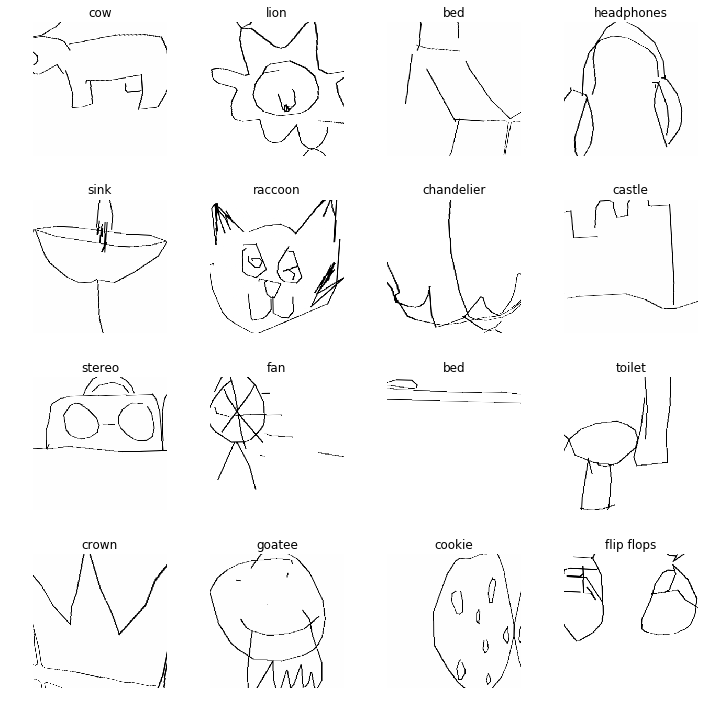

In [9]:
bunch.show_batch(4, figsize=(10, 10))

In [10]:
learn = create_cnn(bunch, models.resnet50, path='..')

In [ ]:
# learn.fit_one_cycle(args['n_epochs'], callbacks=[SaveModelCallback(learn)])

In [ ]:
# learn.save('sz_224')

In [11]:
learn.load('final_224')

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

## Model Interpretation

In [13]:
acc = (interp.pred_class == interp.y_true).float().mean().numpy().item()
print(f'Validation accuracy: {acc:2.2%}')

Validation accuracy: 81.55%


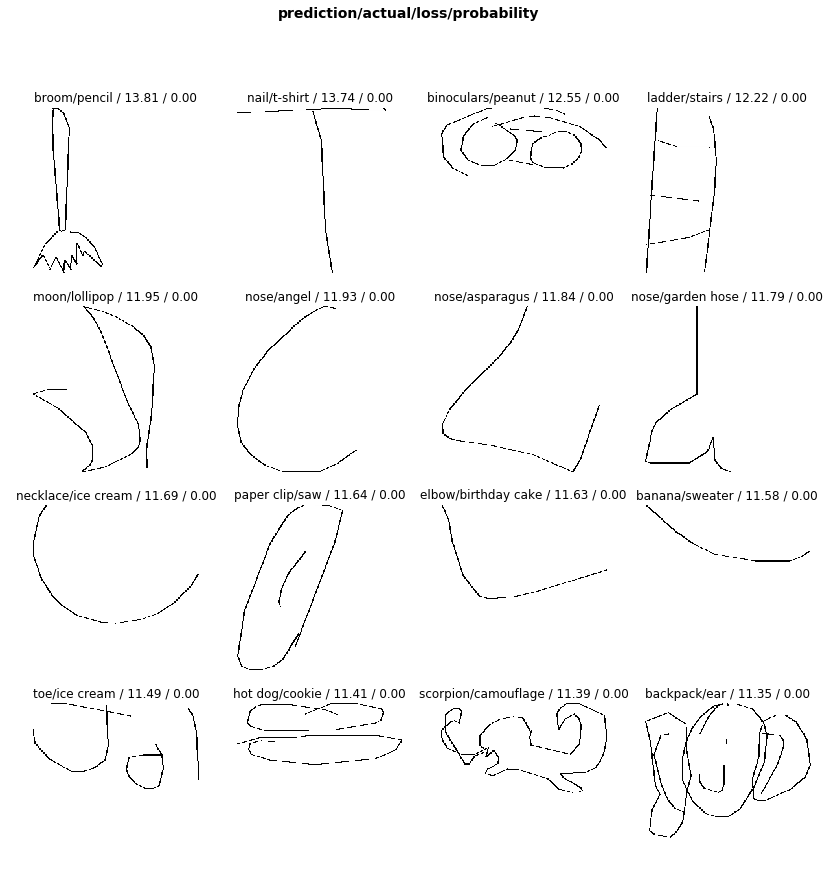

In [14]:
interp.plot_top_losses(k=16, figsize=(14, 14))